## **Muon propagation and hodoscopes**


In order to make our life easier for the next development and debuging seesions, we might want to use **fixed detector configurations**:

 - **Standard configuration**: with 2 sets of 2 hodoscopes placed on top of each other, above and below the passive volume.

 - **Overlap configuration**: with a set of 2 hodoscopes slightly overlaping in $xy$ but not in $z$ above the passive volume.

These methods will be included in the `hodoscope_init_config.py` file.

In [1]:
from volume.hodoscope import Hodoscope
from volume.hodoscopelayer import HodoscopeDetectorLayer
from tomopt.volume import Volume
from tomopt.volume.layer import PassiveLayer

import torch
from torch import nn
from torch import Tensor
from tomopt.core import DEVICE

def get_standard_hod_config() -> Volume:

    init_xyz_span, xyz_gap = [1., 1., .3], [.1, .1, .1]
    init_eff, init_res = 0.90, 1e3

    hods = [Hodoscope(init_xyz= [.5, .5, z], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res
                     ) for z in [1.3, 1.0]]

    hod_detector_above = HodoscopeDetectorLayer(pos = 'above', 
                                                lw = Tensor([1,1]), 
                                                z = 1., size = 0.5, 
                                                hodoscopes = hods)

    # Down

    hods = [Hodoscope(init_xyz= [.5, .5, z], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res
                     ) for z in [0., -.3]]
    
    hod_detector_below = HodoscopeDetectorLayer(pos = 'below', 
                                                lw = Tensor([1,1]), 
                                                z = 1., size = 0.5, 
                                                hodoscopes = hods)

    def get_layers(hod_layers):
        layers = []
        lwh = Tensor([1,1,1])
        size = 0.1
        layers.append(hod_layers[0])
        for z in [0.7,0.6,0.5,0.4,0.3]:
            layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
        layers.append(hod_layers[1])

        return nn.ModuleList(layers)

    return Volume(get_layers([hod_detector_above, hod_detector_below]))

In [2]:
def get_overlap_hod_config() -> Volume:

    init_xyz_span, xyz_gap = [1., 1., .3], [.1, .1, .1]
    init_eff, init_res = 0.90, 1e3

    hods = [Hodoscope(init_xyz= [xy, xy, z], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res
                     ) for xy, z in zip([0., 0.9], [1.3, 1.2])]

    hod_detector_above = HodoscopeDetectorLayer(pos = 'above', 
                                                lw = Tensor([2,2]), 
                                                z = 1., size = 0.5, 
                                                hodoscopes = hods)

    hods = [Hodoscope(init_xyz= [.5, .5, z], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res
                     ) for z in [0.0,-0.3]]
    
    hod_detector_below = HodoscopeDetectorLayer(pos = 'below', 
                                                lw = Tensor([1,1]), 
                                                z = 1., size = 0.5, 
                                                hodoscopes = hods)

    def get_layers(hod_layers):
        layers = []
        lwh = Tensor([1,1,1])
        size = 0.1
        
        layers.append(hod_layers[0])
        for z in [0.7,0.6,0.5,0.4,0.3]:
            layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
        layers.append(hod_layers[1])

        return nn.ModuleList(layers)

    return Volume(get_layers([hod_detector_above, hod_detector_below]))

We might as well create a function that can easly **generates muon beam**.

In [3]:
from typing import Tuple
from tomopt.muon import MuonBatch

def generate_muon_beam(xyz: Tuple[float, float, float] = (.5, .5, 2.0), 
                       theta: float = 0., 
                       phi: float = 0.,
                       mom: float = 4., # GeV 
                       n_muons: int = 10000) -> MuonBatch:
    
    xy_p_theta_phi = torch.ones([n_muons,5])
    xy_p_theta_phi[:,0], xy_p_theta_phi[:,1] = xyz[0], xyz[1]
    xy_p_theta_phi[:,2] = mom
    xy_p_theta_phi[:,3], xy_p_theta_phi[:,4] = theta, phi

    return MuonBatch(init_z = xyz[2], xy_p_theta_phi = xy_p_theta_phi)

### **A - Muons through *standard hodoscope* configuration**

Let's try to **propagate muons** through the volume and make sure that muon **detection runs** smoothly. We will use the **standard detector config** described above.

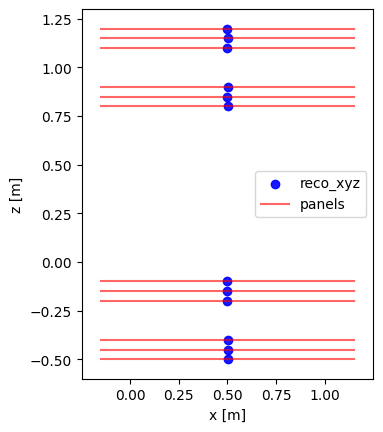

In [6]:
# Generate muons
n_muons = 100
muons = generate_muon_beam(n_muons=n_muons)

# Generate volume
from volume.hodoscope_init_config import get_standard_hod_config
volume = get_standard_hod_config()

# Propagate muons throught the volume
volume(muons)

from plotting.plotting import plot_hits
plot_hits(volume=volume, muons=muons, event = 0, hits = 'reco_xyz')

It seems that the **hits recording** procedure **run smoothly**! Let's check the behaviour of the **ScatterBatch** class.

In [7]:
from tomopt.inference.scattering import ScatterBatch
sb = ScatterBatch(mu = muons, volume = volume)

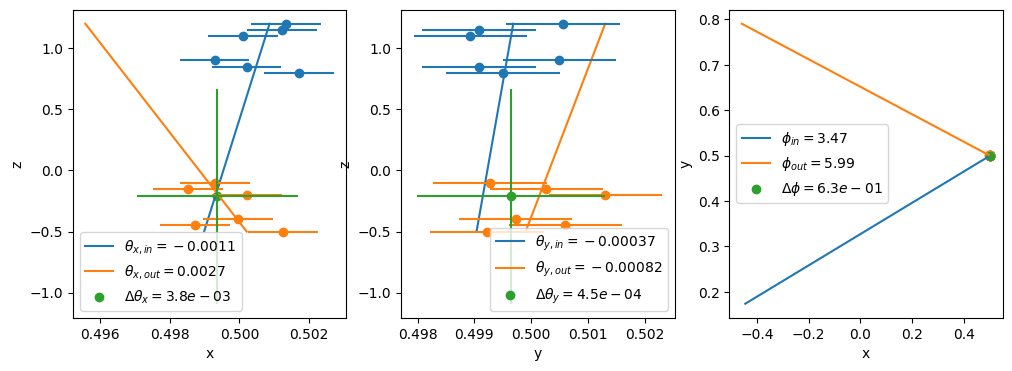

In [8]:
import numpy as np
sb.plot_scatter(idx = np.random.randint(n_muons))

What happens when the hodoscopes are **not placed** directly on **top of each other**?

### **B - Muons through *overlapped hodoscope* configuration**

Let's try to **propagate muons** through the volume and make sure that muon **detection runs** smoothly. We will use the **overlapped hodoscope config** described above.

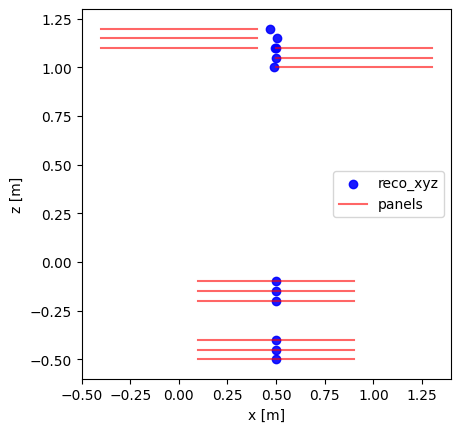

In [11]:
# Generate muons
muons = generate_muon_beam(n_muons=n_muons)

# Generate volume
from volume.hodoscope_init_config import get_overlap_hod_config
volume = get_overlap_hod_config()

# Propagate muons throught the volume
volume(muons)

plot_hits(volume=volume, muons=muons, event = 0, hits = 'reco_xyz')

In [12]:
from tomopt.inference.scattering import ScatterBatch
sb = ScatterBatch(mu = muons, volume = volume)

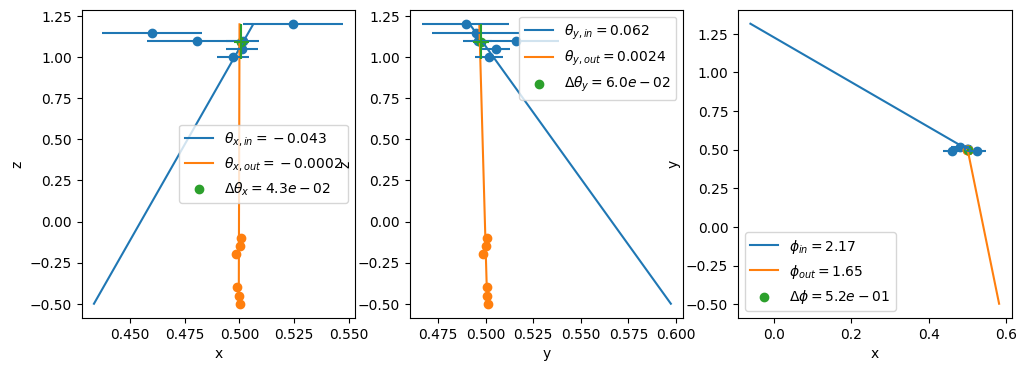

In [13]:
import numpy as np
sb.plot_scatter(idx = np.random.randint(n_muons))

### **C - Hodoscope and volume wrapper**

The `PanelVolumeWrapper` class provide means of predicting the passive volume radiation length and optimizing the detector. Let's check if its current implementation can handle `HodoscopeDetectorLayers`.

A few features and methods have to be modified in order to match the `Hodoscope`'s optimisers:

**Features**:

 - `xy_span_opt`: For the time being, we **do not** wish to **optimise** the **span** of the hodoscope. In the future, it might be the case so our implementation should be **flexible enough**.]
 
 - `z_pos_opt`: Should stay the same.
 - `xy_pos_opt`: Should stay the same.

 - `partial_opts` in `super().__init__()` should be modified accordingly.

**Methods**:

 - `from_save()` should account for the modified features described above.
 - `_build_opt()` should be compatible with `HodoscopeDetectorLayer`.
 

Let's create a `HodoscopeVolumeWrapper` method in a `hodoscope_volume_wrapper.py` file.

**NOTE:** The creation of the final `HodoscopeVolumeWrapper` will require a bit more work, and will deserve its own development notebook.


For now, we will instanciate it with the ***standard configuration*** from section A.

In [15]:
from optimisation.hodoscope_volume_wrapper import HodoscopeVolumeWrapper
from functools import partial
from tomopt.optimisation import VoxelX0Loss

volume = get_standard_hod_config()

wrapper = HodoscopeVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xyz_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))

Define a simple passive volume made of steel and water.

In [16]:
from tomopt.core import X0

def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['water']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

from tomopt.optimisation import PassiveYielder
passives = PassiveYielder([arb_rad_length,arb_rad_length], shuffle=True)


Now we will run the predict function of the wrapper, and check the $X_0$ predictions.

In [17]:
from tomopt.optimisation.callbacks import MuonResampler, ScatterRecord, HitRecord
from tomopt.optimisation import PredHandler, ScatterRecord, HitRecord

sr = ScatterRecord()
hr = HitRecord()
preds = wrapper.predict(PassiveYielder([arb_rad_length]), 
                        n_mu_per_volume=10000, 
                        mu_bs=250, 
                        pred_cb=PredHandler(), 
                        cbs=[MuonResampler(), sr, hr])

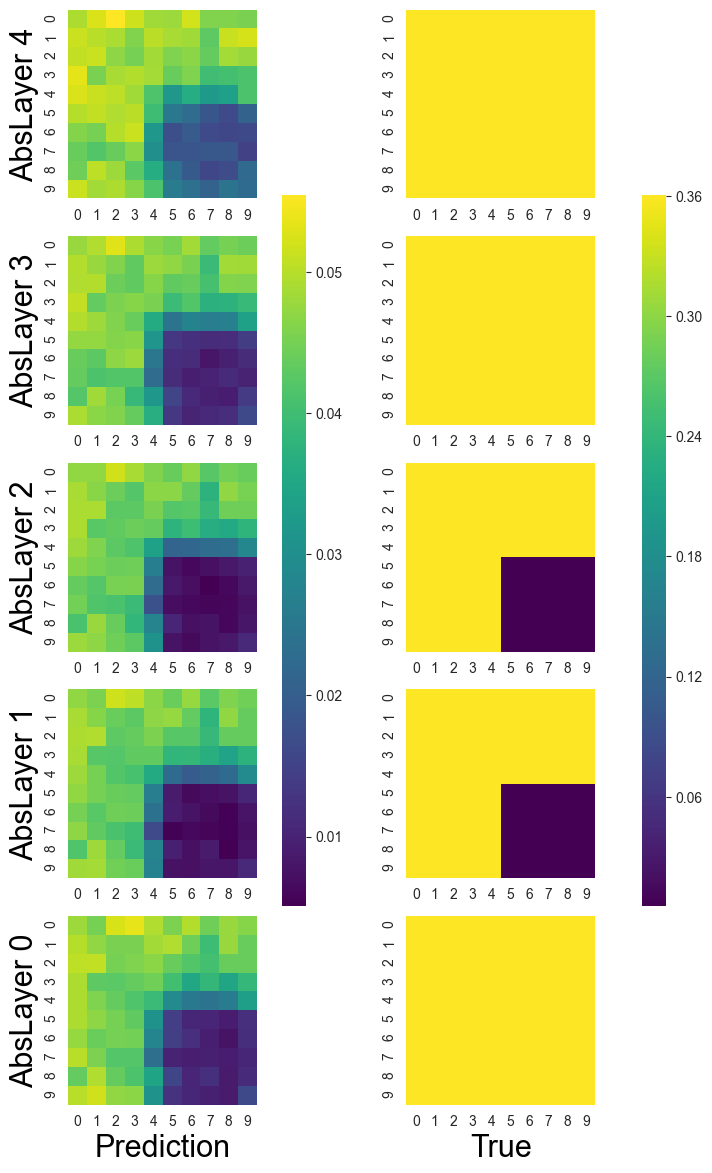

In [18]:
from tomopt.plotting import plot_pred_true_x0
plot_pred_true_x0(preds[0][0], preds[0][1])

It looks really good! Now let's check the prediction behavior for the ***overlap configuartion***:

In [19]:
volume = get_overlap_hod_config()

wrapper = HodoscopeVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xyz_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))

In [20]:
sr = ScatterRecord()
hr = HitRecord()
preds = wrapper.predict(PassiveYielder([arb_rad_length]), 
                        n_mu_per_volume=10000, 
                        mu_bs=250, 
                        pred_cb=PredHandler(), 
                        cbs=[MuonResampler(), sr, hr])

TypeError: nan_to_num(): argument 'input' (position 1) must be Tensor, not NoneType

Here comes the troubles!! We have to understand what is going on here. It appears that there are no POCA point to use for the reconstruction. The `nan_to_num` function should recieve a tensor as input, but since there are no muons, it is `None`.